### Polaron (CDW/SDW) in 1D chain
This example shows how the combination of Hubbard model and electron-phonon coupling can lead to the localization of one electron in a 1d monoatomic chain (again again).

This model has four atoms in the unitcell, the Hamiltonian is as usual, except that there is one electron in this cell(unlike in the other 1d-chain examples, which have one electron per site). 

#### Electron Part
 A H atom chain with 4 atoms as unitcell.

In [5]:
# build the model
import numpy as np
from  minimulti.electron.Hamiltonian import etb_model
from minimulti.electron.basis2 import BasisSet, gen_basis_set, atoms_to_basis
from minimulti.electron.Hubbard import  Dudarev_term
from ase.atoms import Atoms
import matplotlib.pyplot as plt

def gen_model(t=1, U=2, dtdx=0.1, dx=0.0,  spinat=[0, 0, 1, 0], nel=1):
    # generate structure. a chain of 4 H atoms
    atoms=Atoms(symbols='H4', positions=[(0,0,0),(0,0,1-dx), (0,0,2),(0,0,3+dx)], cell=[1,1,4])

    # generate basis set: H s orbitals
    bset= atoms_to_basis(atoms, basis_dict={'H': ('s',)}, nspin=2)

    # generate model. 
    # dim_k: dimension of k space
    # dim_r: dimension of real space.
    # lat: lattice parameter
    # orb: position of orbitals. Here orbs are
    #  0: H (0,0,0) s orbital spin up
    #  1: H (0,0,0) s orbital spin down
    #  2: H (0,0,1) s orbital spin up
    #  3: H (0,0,1) s orbital spin down
    # ....
    #mymodel=etb_model(dim_k=3, dim_r=3, lat=np.diag([1,1,2]), orb=[[0,0,0], [0,0,0], [0,0,1],[0,0,1]], nspin=2)
    mymodel = etb_model(
            dim_k=3, dim_r=3, lat=atoms.get_cell(), orb=bset.get_scaled_positions(), nspin=2)

    # initial magnetic moment.
    mymodel.set_initial_spin(spinat)

    # 1D hopping along z. Format: t, i, j, R. 
    # Note: The hermitian conjugate are automatically setted.
    # spinup
    mymodel.set_hop(t+dtdx*dx, 0,2, [0,0,0])
    mymodel.set_hop(t-dtdx*dx, 2,4, [0,0,0])
    mymodel.set_hop(t-dtdx*dx, 4,6, [0,0,0])
    mymodel.set_hop(t+dtdx*dx, 6,0, [0,0,1])
    # spindown
    mymodel.set_hop(t+dtdx*dx, 1,3, [0,0,0])
    mymodel.set_hop(t-dtdx*dx, 3,5, [0,0,0])
    mymodel.set_hop(t-dtdx*dx, 5,7, [0,0,0])
    mymodel.set_hop(t+dtdx*dx, 7,1, [0,0,1])


    # nel: number of electrons. Mixing: Pulay mixing factor
    # tol_energy: tolerence of energy
    # tol_rho: tolerence of rho
    mymodel.set(nel=nel, mixing=0.05, tol_energy=1e-7, tol_rho=1e-7, sigma=0.15)

    # SU(N) Hubbard Term.
    Uterm=Dudarev_term(bset=bset, Hubbard_dict={'H': {'L':0, 'U': U, 'J': 0}})
    mymodel.set_U_term(Uterm)
    # K mesh.
    mymodel.set_kmesh([1,1,70])
    # Scf solve
    mymodel.scf_solve(print_iter_info=False)
    return mymodel

def Elatt(dx, k):
    return 4* 0.5 * k * dx**2

#### lattice part
$E_{latt}=\frac{1}{2} \sum_i k  (\Delta x_i)^2$

First, we plot the energy as the function of the displacement of atoms. We can find that the energy minimum is at about $dx=-0.25$

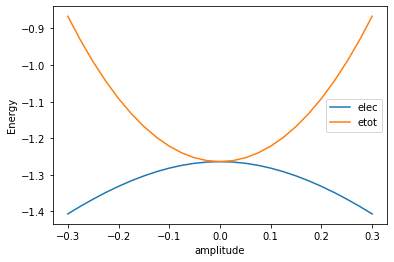

In [10]:
%matplotlib inline
def E_vs_dx(k=3):
    dx_list=np.arange(-0.3,0.31,0.025)
    E_latt=[]
    E_elec=[]
    E_tot=[]
    for dx in dx_list:
        mymodel=gen_model(t=1, U=1.4, dtdx=1, dx=dx,  spinat=[0, 0, 1, 0], nel=1)
        E_elec.append(mymodel._total_energy)
        E_latt.append(Elatt(dx, k))
    #print(E_latt)
    #print(E_elec)
    E_tot=np.array(E_latt)+np.array(E_elec)
    plt.plot(dx_list, E_elec, label='elec')
    #plt.plot(dx_list, E_latt, label='latt')
    plt.plot(dx_list, E_tot, label='etot')
    plt.xlabel('amplitude')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()
E_vs_dx()

We can take a took at the electronic structure in the energy minimum. It shows that the system is insulating, 

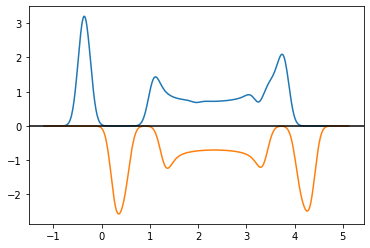

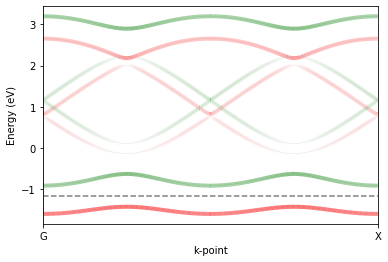

In [7]:
%matplotlib inline
mymodel=gen_model(t=1, U=2.4, dtdx=1, dx=-0.25,  spinat=[0, 0, 1, 0], nel=1)
mymodel.plot_dos()
mymodel.plot_projection_band(
        color_dict={4: 'red', # H2 spin up
                    5: 'green', # H2 spin down
                    },
        kvectors=[[0,0,0],[0,0,0.5]],
        knames=['G','X'],
        npoints=400,
        supercell_matrix=np.diag([1,1,4])
)
#plt.savefig('band%s.png'%dx)
plt.show()

#### Charges and magnetic moments
Now we plot the charge and spin for each atom. It can be seen that the charge distribution (This model is probably better called a charge density wave state or spin density state rather than a polaron.)

charges:  [0.0382748  0.20236058 0.55700405 0.20236058 0.0382748 ]
magmoms:  [0.02400301 0.16796612 0.50194808 0.16796612 0.02400301]


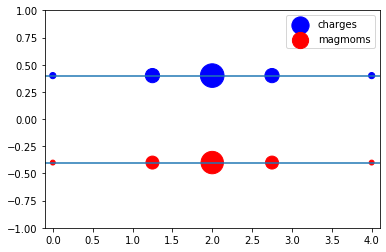

In [8]:
%matplotlib inline
def plot_density(dx=-0):
    mymodel=gen_model(t=1, U=2.5, dtdx=1, dx=dx,  spinat=[0, 0, 1, 0], nel=1)

    x=[0,1-dx,2,3+dx, 4]
    y=np.zeros(5)
    charges=mymodel.get_charges()
    # periodic boundary condition to make the picture more symmetric
    charges=charges[::2]+charges[1::2]
    charges=np.append(charges, charges[0])
    magmoms=mymodel.get_magnetic_moments()
    magmoms=np.append(magmoms, magmoms[0])
    print("charges: ", charges)
    print("magmoms: ", magmoms)
    plt.figure()
    plt.xlim(-0.1,4.1)
    plt.ylim(-1,1)
    plt.axhline(0.4)
    plt.axhline(-0.4)
    plt.scatter(x, y+0.4, s=charges*1000, color='blue', label='charges')
    plt.scatter(x, y-0.4, s=magmoms*1000, color='red', label='magmoms')
    plt.legend()
    plt.show()
    
plot_density(dx=-0.25)